#Obtención y merjoramiento de la imagen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import signal
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path = '/content/drive/MyDrive/Tp PSIB/IMAGENES/img1.jpg'

TypeError: Image data of dtype object cannot be converted to float

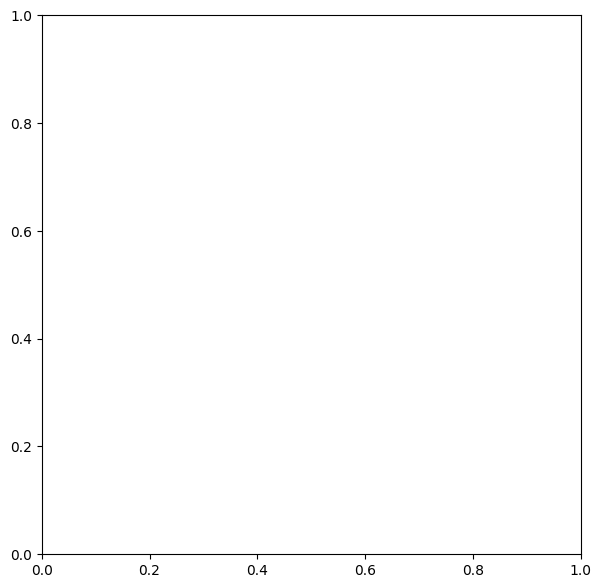

In [8]:
img = cv2.imread(path,0)
plt.figure(figsize=(7,7))
plt.imshow(img, cmap="gray",vmin=0, vmax=255)
plt.axis(False)
plt.show()

In [ ]:
#Generamos histograma
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()#acumulado
cdf_normalized = cdf *hist.max() / cdf.max()#lo normalizo

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(img,cmap="gray")
ax[0].axis(False)
ax[0].set_title("Imagen original")

ax[1].hist(np.ravel(img), bins=256, range=(0,255))
ax[1].plot(cdf_normalized)
ax[1].set_title("Histograma acumulado")
plt.show()


In [ ]:
#Ecualizamos
img_ec = cv2.equalizeHist(img)
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()#acumulado
cdf_normalized = cdf *hist.max() / cdf.max()#lo normalizo
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(img,cmap="gray")
ax[0].axis(False)
ax[0].set_title("Imagen original")

ax[1].hist(np.ravel(img), bins=256, range=(0,255))
ax[1].plot(cdf_normalized)
ax[1].set_title("Histograma acumulado")
plt.show()

hist,bins = np.histogram(img_ec.flatten(),256,[0,256])
cdf = hist.cumsum()#acumulado
cdf_normalized = cdf *hist.max() / cdf.max()#lo normalizo
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(img_ec,vmin=0, vmax=255,cmap='gray')
ax[0].set_title('Imagen ecualizada')
ax[0].axis(False)
ax[1].hist(np.ravel(img_ec), bins=256, range=(0,255))
ax[1].plot(cdf_normalized)
ax[1].set_title("Histograma ecualizado acumulado")
plt.show()

Para encontrar el calculo y poder segmentarlo, primeramente hay que **binarizar la imagen**. Para ello, conviene aplicar alguno de los metodos de umbralizado, como Otsu. Sin embargo, este último actua mejor sobre histogramas bimodales, por lo que la ecualización de la imagen no es útil en este caso.

In [ ]:
umbral, img_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(umbral)
plt.figure(figsize=(7,7))
plt.imshow(img_otsu, cmap="gray",vmin=0, vmax=255)
plt.axis(False)
plt.show()